Prediksi umur abalone menggunakan kondisi pengukuran fisik. Umur abalone ditentukan dengan memotong cangkangnya, menodai, dan menghitung jumlah 'ring' melalui mikroskop.


*   Sex 			: Male, Female, and I (infant)
*   Length 		: Panjang cangkang dalam milimeter
*   Diameter 		: Diameter dalam milimeter
*   Height 			: Tinggi termasuk daging dalam cangkang dalam milimeter
*   Whole weight 		: Berat keseluruhan abalone dalam gram
*   Shucked weight	: Berat daging abalone gram
*   Viscera weight 	: Berat usus abalone setelah dikeringkan gram
*   Shell weight 		: Berat cangkang setelah dikeringkan gram
*   Rings 			: Jumlah rings yang jika ditambahkan 1.5 akan menunjukkan umur abalon 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_csv('/content/gdrive/MyDrive/DSU/Project 2 DSU Batch 2/Salinan Abalone.csv')
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


Karena kita ingin memprediksi umur (Age), maka variabel Age nantinya akan menjadi variabel dependen atau target. Akan tetapi variabel age belum ada, maka harus dibuat terlebih dahulu. Berdasarkan dari deskripsi pada dataset, kolom Age bisa didapat dari penjumlahan 1.5 dengan data setiap row di kolom Rings

In [5]:
df["Age"] = df["Rings"] + 1.5

In [6]:
# memisahkan features dan target
y = df.Age
X = df.drop(['Age'], axis=1)

In [7]:
# membagi dataset menjadi train set dan validation set (80 20)
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

## Metode 1 Drop Sex

In [8]:
drop_X_train = X_train_full.select_dtypes(exclude=['object'])
drop_X_valid = X_valid_full.select_dtypes(exclude=['object'])

In [9]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(drop_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
# Mencari nilai R - squared untuk mengukur explanatory power dari features
r2 = reg.score(drop_X_valid, y_valid)
r2

1.0

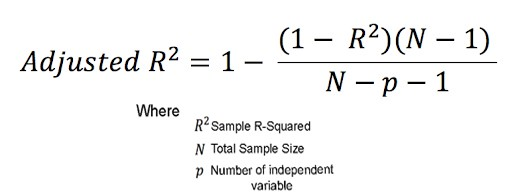

In [11]:
def adjusted_r2(r2, n, p):
  return 1 - (((1-r2)*(n-1)) / (n-p-1))

In [12]:
drop_X_valid.shape

(836, 8)

In [13]:
# adjusted r2
n = drop_X_valid.shape[0]
p = drop_X_valid.shape[1]
adjusted_r2(r2, n, p)


1.0

## Metode 2 Drop Sex + Drop Rings

In [14]:
dropRings_Xtrain = drop_X_train.drop("Rings", axis=1)
dropRings_Xvalid = drop_X_valid.drop("Rings", axis=1)

In [15]:
reg.fit(dropRings_Xtrain, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# Mencari nilai R - squared untuk mengukur explanatory power dari features
r2 = reg.score(dropRings_Xvalid, y_valid)
r2

0.5300888107050662

In [17]:
dropRings_Xvalid.shape

(836, 7)

In [18]:
# adjusted r2
n = dropRings_Xvalid.shape[0]
p = dropRings_Xvalid.shape[1]
adjusted_r2(r2, n, p)

0.5261161315685148

## Metode 3 One-Hot-Encoding Sex + Drop Rings

In [19]:
X_train_full = X_train_full.drop("Rings", axis=1)
X_valid_full = X_valid_full.drop("Rings", axis=1)

In [20]:
from sklearn.preprocessing import OneHotEncoder

X_train_full["Sex"] = X_train_full['Sex'].astype('category').cat.codes.astype("float")
X_valid_full["Sex"] = X_valid_full['Sex'].astype('category').cat.codes.astype("float")

OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train_full[["Sex"]]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid_full[["Sex"]]))


# One-hot encoding removed index; put it back
OH_cols_train.index = X_train_full.index
OH_cols_valid.index = X_valid_full.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train_full.drop("Sex", axis=1)
num_X_valid = X_valid_full.drop("Sex", axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

In [21]:
reg.fit(OH_X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
r2 = reg.score(OH_X_valid, y_valid)
r2

0.5383751781320009

In [23]:
OH_X_valid.shape

(836, 10)

In [24]:
# adjusted r2
n = OH_X_valid.shape[0]
p = OH_X_valid.shape[1]
adjusted_r2(r2, n, p)

0.5327797257457221

In [25]:
# Fungsi untuk melihat skor RMSE

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def ols_score(X_train, X_valid, y_train, y_valid):
  model = LinearRegression()
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  return mean_squared_error(y_valid, preds)

def rf_score(X_train, X_valid, y_train, y_valid):
  model = RandomForestRegressor(n_estimators=50, random_state=1)
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  return mean_squared_error(y_valid, preds)

def xgb_score(X_train, X_valid, y_train, y_valid):
  model = XGBRegressor()
  model.fit(X_train, y_train)
  preds = model.predict(X_valid)
  return mean_squared_error(y_valid, preds)

In [26]:
ols_score(OH_X_train, OH_X_valid, y_train, y_valid)

5.013389185855263

In [27]:
rf_score(OH_X_train, OH_X_valid, y_train, y_valid)

4.804708612440192

In [28]:
xgb_score(OH_X_train, OH_X_valid, y_train, y_valid)

[16:48:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


4.78463528391867

In [31]:
import tensorflow as tf


model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
model.fit(OH_X_train, y_train, epochs=500)


Epoch 1/500
105/105 [==============================] - 1s 3ms/step - loss: 41.4410 - mse: 41.4410
Epoch 2/500
105/105 [==============================] - 0s 3ms/step - loss: 6.9290 - mse: 6.9290
Epoch 3/500
105/105 [==============================] - 0s 3ms/step - loss: 6.4319 - mse: 6.4319
Epoch 4/500
105/105 [==============================] - 0s 3ms/step - loss: 6.1446 - mse: 6.1446
Epoch 5/500
105/105 [==============================] - 0s 3ms/step - loss: 5.9807 - mse: 5.9807
Epoch 6/500
105/105 [==============================] - 0s 3ms/step - loss: 5.6584 - mse: 5.6584
Epoch 7/500
105/105 [==============================] - 0s 3ms/step - loss: 5.4003 - mse: 5.4003
Epoch 8/500
105/105 [==============================] - 0s 3ms/step - loss: 5.2350 - mse: 5.2350
Epoch 9/500
105/105 [==============================] - 0s 3ms/step - loss: 5.0713 - mse: 5.0713
Epoch 10/500
105/105 [==============================] - 0s 3ms/step - loss: 4.9388 - mse: 4.9388
Epoch 11/500
105/105 [===============

In [32]:
model.evaluate(OH_X_valid, y_valid, verbose=0)

[4.506470203399658, 4.506470203399658]